### Fusion des bases de données `df_regressions` et `ee_bp19`

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [33]:
df1 = pd.read_csv("df_regressions.csv")
df2 = pd.read_csv("ee_bp19.csv")
# Fusion des deux dataframes
df = df1.merge(df2, on="Dep")

In [34]:
df.head()

,Dep,D9/D1,Rev_median,Ndip25_34,intens_pauvr,chom19,chom24,Dem_empl15_64,tauxpauvrete,G,C,D
0,Ain,3.5,24810.0,11.5,20.4,6.050,5.600,10.3,10.8,0.247537,0.327883,0.424580
1,Aisne,3.1,20920.0,17.6,20.1,11.800,10.500,15.8,18.8,0.201414,0.237194,0.561392
2,Allier,3.0,21500.0,14.8,20.1,9.050,7.925,13.7,16.2,0.260370,0.306293,0.433337
3,Alpes-de-Haute-Provence,3.2,21790.0,12.7,20.5,10.075,7.925,16.0,17.1,0.298026,0.291808,0.410167
4,Hautes-Alpes,3.0,22010.0,9.7,19.9,7.925,6.225,15.8,14.7,0.306485,0.313522,0.379994


### Régression linéaire

In [35]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [36]:
# On écrit une fonction qui va réaliser la régression linéaire

def reglin(df, var):
    
    # variables explicatives (X) et cibles (Y)
    features_cols = ['D9/D1', 'Rev_median', 'Ndip25_34', var, 'Dem_empl15_64', 'tauxpauvrete']

    X = df[features_cols]

    # On standardise pour comparer l'importance des coefficients
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=features_cols)

    X_final = sm.add_constant(X_scaled)

    # --- RÉGRESSIONS ET AFFICHAGE COMPLET ---
    partis = {'GAUCHE': 'G', 'CENTRE': 'C', 'DROITE': 'D'}

    resume_significativite = pd.DataFrame(index=features_cols)

    print(" ANALYSE ÉCONOMÉTRIQUE COMPLÈTE ".center(80, "="))

    for nom, col in partis.items():
        y = df[col]
        
        # Ajustement du modèle
        model = sm.OLS(y, X_final)
        
        try:
            results = model.fit(cov_type="HC1") 
            
            print(f"\n\n{'#'*30}")
            print(f" RÉSULTATS POUR : {nom} ")
            print(f"{'#'*30}")
            
            # On affiche le résumé complet
            print(results.summary())
            
            # On stocke les p-valeurs pour une vue d'ensemble à la fin
            resume_significativite[f'P-val {nom}'] = results.pvalues.drop('const')
            
        except Exception as e:
            print(f"\nErreur sur {nom} (probablement pas assez de données dans l'échantillon test) : {e}")

    # --- Variables explicatives et P_valeurs ---
    print("\n\n" + "="*80)
    print(" RÉSUMÉ DES P-VALEURS (Seuil : 5%) ")
    print("="*80)
    print(resume_significativite.round(4))



In [37]:
# On lance la regression
reglin(df, 'chom19')

======================== ANALYSE ÉCONOMÉTRIQUE COMPLÈTE ========================


##############################
 RÉSULTATS POUR : GAUCHE 
##############################
                            OLS Regression Results                            
Dep. Variable:                      G   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     16.63
Date:                Wed, 24 Dec 2025   Prob (F-statistic):           1.24e-12
Time:                        12:27:18   Log-Likelihood:                 191.63
No. Observations:                  93   AIC:                            -369.3
Df Residuals:                      86   BIC:                            -351.5
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                    coef    std err    

##### Vérification modèle de régression linéaire

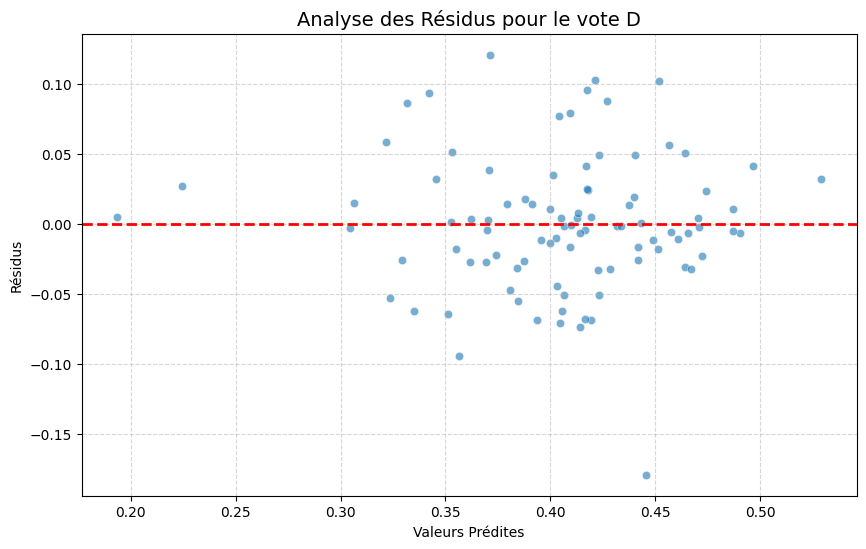

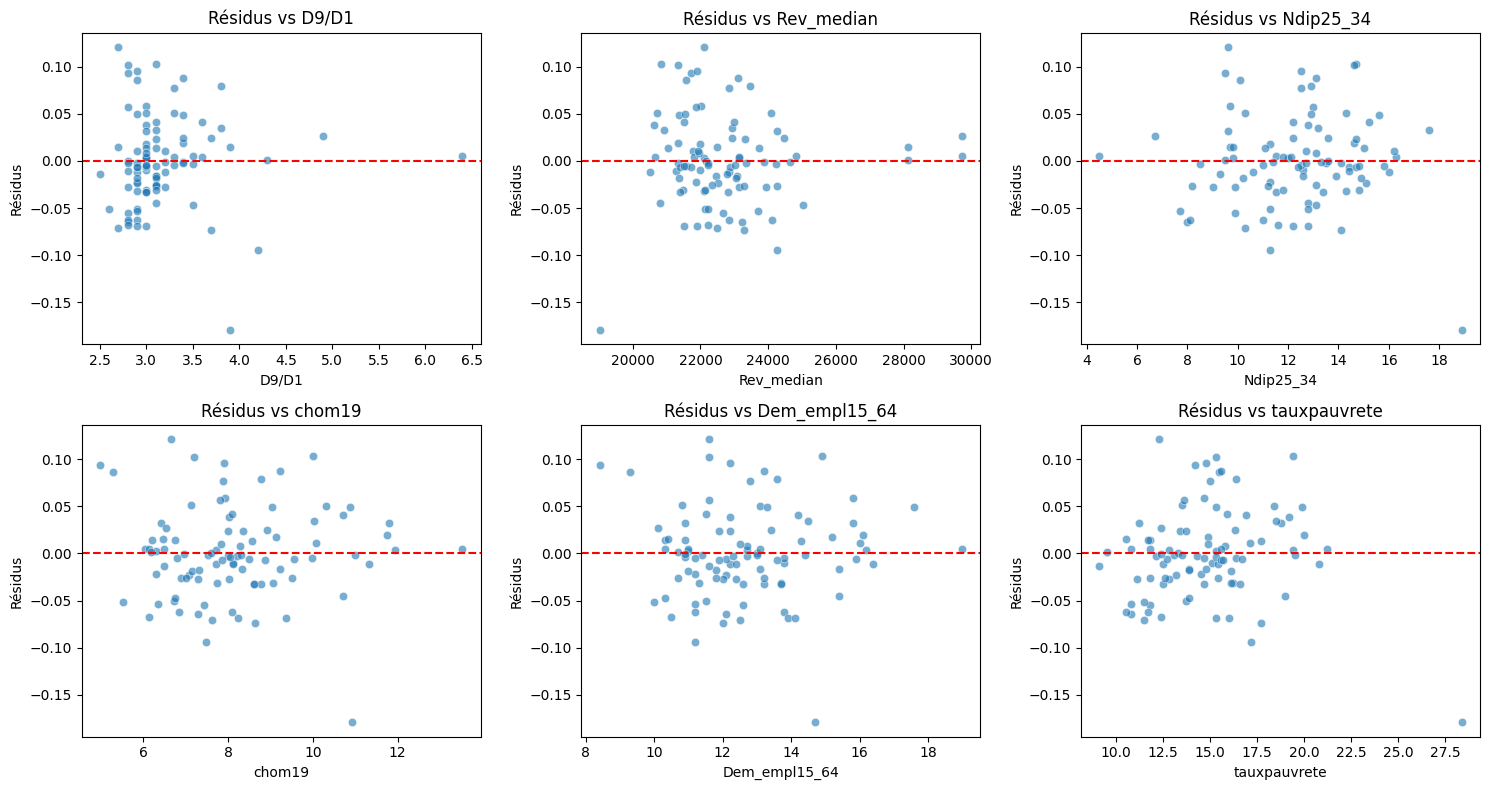

--- Corrélation entre les résidus et les variables explicatives (D) ---
D9/D1           -9.163010e-16
Rev_median      -4.223472e-16
Ndip25_34       -2.062336e-16
chom19          -7.283506e-16
Dem_empl15_64   -7.865025e-16
tauxpauvrete    -4.963905e-16
dtype: float64


In [38]:

# Remplacer 'target_col' par G ou C pour visualiser pour les autres partis

target_col = 'D' 
y = df[target_col]

model = sm.OLS(y, X_final)
try:
    results = model.fit(cov_type='HC1')
    
    # On récupère les résidus et les prédictions
    residus = results.resid
    predictions = results.fittedvalues
    
    # ==============================================================================
    # RÉSIDUS vs VALEURS PRÉDITES 
    # ==============================================================================
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=predictions, y=residus, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', lw=2) # Ligne zéro
    plt.title(f'Analyse des Résidus pour le vote {target_col}', fontsize=14)
    plt.xlabel('Valeurs Prédites')
    plt.ylabel('Résidus')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # ==============================================================================
    # RÉSIDUS vs VARIABLES EXPLICATIVES
    # ==============================================================================
    
    # On selectionne les variables principales (excluant la constante)
    vars_to_check = features_cols 
    
    # Graphique
    n_cols = 3
    n_rows = (len(vars_to_check) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten() # Aplatir pour itérer facilement

    for i, col_name in enumerate(vars_to_check):
        sns.scatterplot(x=df[col_name], y=residus, ax=axes[i], alpha=0.6)
        axes[i].axhline(0, color='red', linestyle='--', lw=1.5)
        axes[i].set_title(f'Résidus vs {col_name}')
        axes[i].set_ylabel('Résidus')
        axes[i].set_xlabel(col_name)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # ==============================================================================
    # CORRÉLATION
    # ==============================================================================
    print(f"--- Corrélation entre les résidus et les variables explicatives ({target_col}) ---")
    correlation_check = df[features_cols].apply(lambda x: x.corr(residus))
    print(correlation_check)

except Exception as e:
    print(f"Erreur (probablement due au manque de données dans l'échantillon test) : {e}")

    On constate que les corrélations sont proches de 0.

### Résumé global de l'analyse pour 2019

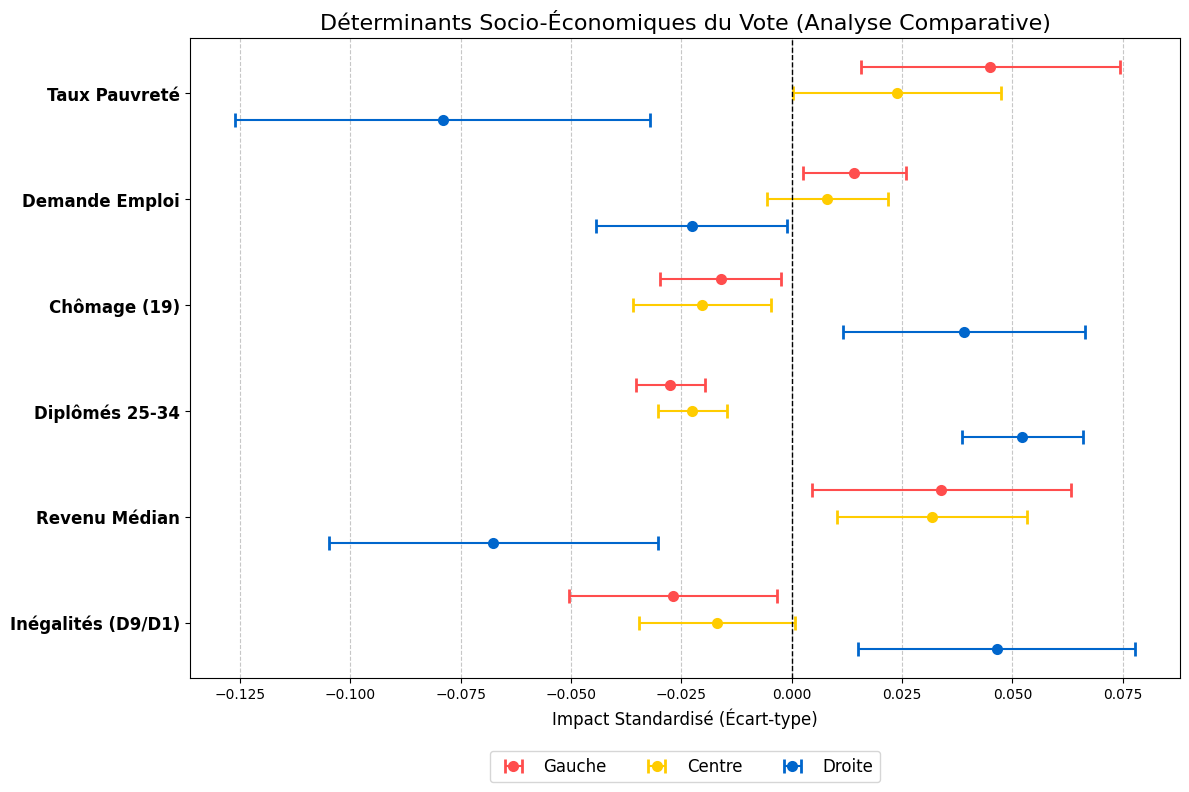

In [39]:
# On copie les valeurs exactes (Coefs et erreurs) de la régression précédente

data_viz = {
    'Variable': ['Inégalités (D9/D1)', 'Revenu Médian', 'Diplômés 25-34', 
                 'Chômage (19)', 'Demande Emploi', 'Taux Pauvreté'],
    
    # GAUCHE 
    'G_coef': [-0.0269, 0.0339, -0.0275, -0.0161, 0.0142, 0.0450],
    'G_err':  [0.012,   0.015,  0.004,   0.007,   0.006,  0.015],
    
    # CENTRE 
    'C_coef': [-0.0169, 0.0317, -0.0225, -0.0204, 0.0080, 0.0239],
    'C_err':  [0.009,   0.011,  0.004,   0.008,   0.007,  0.012],
    
    # DROITE 
    'D_coef': [0.0464, -0.0676, 0.0522, 0.0390, -0.0227, -0.0791],
    'D_err':  [0.016,   0.019,  0.007,   0.014,   0.011,   0.024]
}

df_viz = pd.DataFrame(data_viz)

# Calcul des intervalles de confiance à 95% (1.96 * StdErr)
df_viz['G_ci'] = df_viz['G_err'] * 1.96
df_viz['C_ci'] = df_viz['C_err'] * 1.96
df_viz['D_ci'] = df_viz['D_err'] * 1.96

# Graphique
fig, ax = plt.subplots(figsize=(12, 8))

y_pos = np.arange(len(df_viz))
height = 0.25  # Épaisseur des barres

colors = {'G': '#ff4d4d', 'C': '#ffcc00', 'D': '#0066cc'} # Rouge, Jaune, Bleu

# On visualise chaque parti

# GAUCHE
ax.errorbar(df_viz['G_coef'], y_pos + height, xerr=df_viz['G_ci'], 
            fmt='o', color=colors['G'], label='Gauche', capsize=5, markeredgewidth=2)

# CENTRE
ax.errorbar(df_viz['C_coef'], y_pos, xerr=df_viz['C_ci'], 
            fmt='o', color=colors['C'], label='Centre', capsize=5, markeredgewidth=2)

# DROITE
ax.errorbar(df_viz['D_coef'], y_pos - height, xerr=df_viz['D_ci'], 
            fmt='o', color=colors['D'], label='Droite', capsize=5, markeredgewidth=2)

ax.set_yticks(y_pos)
ax.set_yticklabels(df_viz['Variable'], fontsize=12, fontweight='bold')
ax.axvline(0, color='black', linestyle='--', linewidth=1) # Ligne zéro
ax.set_xlabel('Impact Standardisé (Écart-type)', fontsize=12)
ax.set_title('Déterminants Socio-Économiques du Vote (Analyse Comparative)', fontsize=16)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

L'analyse des données nous montre clairement que le paysage politique français est coupé en trois, et que chaque camp correspond à une réalité économique bien précise. Ce n'est plus seulement une question d'idées : on voit que la situation financière et sociale du département joue un rôle majeur dans la façon dont les gens votent.

Le vote du Centre est sans doute le plus simple à comprendre : c'est le vote de la stabilité et de la réussite économique. Les chiffres sont très clairs là-dessus, puisque ce bloc réalise ses meilleurs scores dans les départements où le niveau de vie est élevé. À l'inverse, c'est un vote qui ne supporte pas la crise : dès que le chômage augmente, le score du Centre s'effondre. C'est donc le choix privilégié de la "France qui va bien", celle qui a intérêt à ce que le système ne change pas trop.

Pour la Droite, c'est exactement l'inverse. Ce vote se nourrit des fractures sociales. Il est particulièrement fort là où il y a du chômage et là où les inégalités de revenus sont les plus criantes. C'est clairement l'expression d'une colère ou d'un sentiment de déclassement. Il y a tout de même une nuance importante à saisir : la Droite ne fait pas le plein dans les zones de grande pauvreté. Elle semble plutôt attirer ceux qui travaillent mais qui rament, ou qui ont peur de descendre l'échelle sociale, tout en rejetant ce qu'ils perçoivent comme de l'assistanat.

Enfin, la Gauche conserve son rôle historique de protecteur. Son moteur principal reste la pauvreté : plus un département est en difficulté, plus il vote à Gauche pour chercher du soutien public. Son grand problème, c'est qu'elle ne capte plus le "vote chômage", qui est parti à Droite. On remarque aussi quelque chose d'intéressant : une fois qu'on met la pauvreté de côté, on voit que des gens avec de bons revenus continuent de voter à Gauche, ce qui correspond probablement aux citadins et aux classes moyennes éduquées des grandes villes.

# Analyse pour l'année 2024

### Fusion des bases de données `df_regressions` et `ee_bp24`

In [40]:
df1 = pd.read_csv("df_regressions.csv").drop(columns='chom19') # On supprime le chomage de 2019
df2 = pd.read_csv("ee_bp24.csv")
# Fusion des deux dataframes
df = df1.merge(df2, on="Dep")

In [41]:
df.head()

,Dep,D9/D1,Rev_median,Ndip25_34,intens_pauvr,chom24,Dem_empl15_64,tauxpauvrete,G,C,D
0,Ain,3.5,24810.0,11.5,20.4,5.600,10.3,10.8,0.191325,0.277548,0.531127
1,Aisne,3.1,20920.0,17.6,20.1,10.500,15.8,18.8,0.152445,0.199770,0.647786
2,Allier,3.0,21500.0,14.8,20.1,7.925,13.7,16.2,0.205709,0.260076,0.534215
3,Alpes-de-Haute-Provence,3.2,21790.0,12.7,20.5,7.925,16.0,17.1,0.237065,0.272583,0.490352
4,Hautes-Alpes,3.0,22010.0,9.7,19.9,6.225,15.8,14.7,0.239572,0.313148,0.447279


#### Régression linéaire 

In [42]:
reglin(df, 'chom24')

======================== ANALYSE ÉCONOMÉTRIQUE COMPLÈTE ========================


##############################
 RÉSULTATS POUR : GAUCHE 
##############################
                            OLS Regression Results                            
Dep. Variable:                      G   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     11.62
Date:                Wed, 24 Dec 2025   Prob (F-statistic):           1.71e-09
Time:                        12:27:20   Log-Likelihood:                 175.11
No. Observations:                  93   AIC:                            -336.2
Df Residuals:                      86   BIC:                            -318.5
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                    coef    std err    

### Résumé graphique

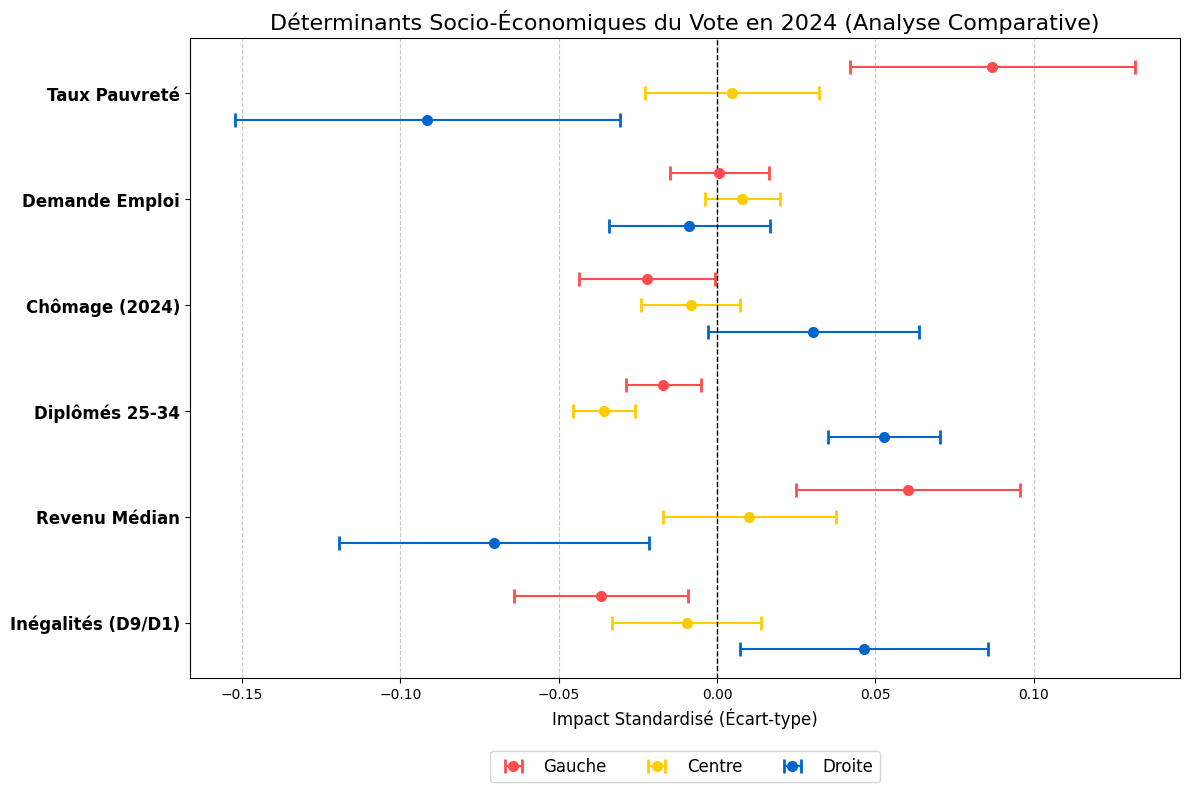

In [46]:
# On copie les valeurs exactes (Coefs et erreurs) de la régression précédente

data_viz_2024 = {
    'Variable': ['Inégalités (D9/D1)', 'Revenu Médian', 'Diplômés 25-34', 
                 'Chômage (2024)', 'Demande Emploi', 'Taux Pauvreté'],
    
    # GAUCHE 2024 (Rappel : Pauvreté explose, Revenu positif)
    'G_coef': [-0.0367, 0.0603, -0.0170, -0.0221, 0.0007, 0.0869],
    'G_err':  [0.014,   0.018,  0.006,   0.011,   0.008,  0.023],
    
    # CENTRE 2024 (Rappel : Revenu et Chômage devenus non significatifs)
    'C_coef': [-0.0096, 0.0102, -0.0358, -0.0083, 0.0080, 0.0046],
    'C_err':  [0.012,   0.014,  0.005,   0.008,   0.006,  0.014],
    
    # DROITE 2024 (Rappel : Rejet Richesse et Pauvreté, aime Inégalités)
    'D_coef': [0.0464, -0.0705, 0.0528, 0.0303, -0.0088, -0.0915],
    'D_err':  [0.020,   0.025,  0.009,   0.017,   0.013,  0.031]
}

df_viz = pd.DataFrame(data_viz_2024)

# Calcul des intervalles de confiance à 95% (1.96 * StdErr)
df_viz['G_ci'] = df_viz['G_err'] * 1.96
df_viz['C_ci'] = df_viz['C_err'] * 1.96
df_viz['D_ci'] = df_viz['D_err'] * 1.96

# Graphique
fig, ax = plt.subplots(figsize=(12, 8))

y_pos = np.arange(len(df_viz))
height = 0.25  # Épaisseur des barres

colors = {'G': '#ff4d4d', 'C': '#ffcc00', 'D': '#0066cc'} # Rouge, Jaune, Bleu

# On visualise chaque parti

# GAUCHE
ax.errorbar(df_viz['G_coef'], y_pos + height, xerr=df_viz['G_ci'], 
            fmt='o', color=colors['G'], label='Gauche', capsize=5, markeredgewidth=2)

# CENTRE
ax.errorbar(df_viz['C_coef'], y_pos, xerr=df_viz['C_ci'], 
            fmt='o', color=colors['C'], label='Centre', capsize=5, markeredgewidth=2)

# DROITE
ax.errorbar(df_viz['D_coef'], y_pos - height, xerr=df_viz['D_ci'], 
            fmt='o', color=colors['D'], label='Droite', capsize=5, markeredgewidth=2)

ax.set_yticks(y_pos)
ax.set_yticklabels(df_viz['Variable'], fontsize=12, fontweight='bold')
ax.axvline(0, color='black', linestyle='--', linewidth=1) # Ligne zéro
ax.set_xlabel('Impact Standardisé (Écart-type)', fontsize=12)
ax.set_title('Déterminants Socio-Économiques du Vote en 2024 (Analyse Comparative)', fontsize=16)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

L'analyse comparative entre les deux périodes met en lumière une recomposition majeure des déterminants économiques du vote, particulièrement visible au niveau du bloc central. Alors que les modèles précédents identifiaient le Centre comme le vote de la stabilité économique, fortement corrélé à la richesse des territoires et à la faiblesse du chômage, l'année 2024 marque une rupture statistique nette. Les indicateurs de revenu médian et de chômage perdent leur significativité, suggérant que le vote centriste s'est déconnecté de ses ancrages matériels traditionnels. Il ne s'appuie plus sur une géographie des "gagnants" de l'économie, mais semble flotter sociologiquement, ne conservant comme marqueur structurel fort que sa difficulté persistante à capter le vote des jeunes diplômés.

Parallèlement, la dynamique électorale à Gauche témoigne d'une polarisation sociologique accrue, illustrant un phénomène de "grand écart" territorial. D'une part, la corrélation avec le taux de pauvreté s'est considérablement intensifiée, confirmant le rôle de refuge de la Gauche pour les zones les plus précarisées. D'autre part, l'influence positive du revenu médian s'est également renforcée, validant l'hypothèse d'un ancrage croissant au sein de catégories urbaines plus aisées. Cette double dynamique contraste avec l'incapacité continue de ce bloc à capter le "vote chômage", confirmant la fracture entre une gauche des métropoles et des quartiers prioritaires, et un électorat populaire intermédiaire qui lui échappe toujours.

Enfin, la Droite consolide sa position spécifique en s'affirmant comme le vote des territoires en tension, pris en étau entre richesse et grande exclusion. Les résultats de 2024 montrent un rejet explicite de ce bloc tant par les départements les plus riches que par les zones de pauvreté monétaire intense, contrairement à la Gauche. La Droite performe ainsi dans l'espace intermédiaire, capitalisant sur les inégalités de revenus et le sentiment de déclassement économique, sans pour autant parvenir à s'implanter dans les foyers de précarité les plus profonds. Cette configuration dessine une tripartition où chaque bloc occupe désormais un segment distinct de la réalité sociale : la précarité et l'aisance urbaine pour la Gauche, le déclassement intermédiaire pour la Droite, et une position centrale devenue économiquement illisible.